In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
import itertools
import random
import node2vec_lib


In [16]:
import numpy as np
import networkx as nx
import random
from gensim.models import Word2Vec


class Graph():
    def __init__(self, nx_G, is_directed, p, q):
        self.G = nx_G
        self.is_directed = is_directed
        self.p = p
        self.q = q

    def node2vec_walk(self, walk_length, start_node):
        '''
        Simulate a random walk starting from start node.
        '''
        G = self.G
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges

        walk = [start_node]

        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = sorted(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                if len(walk) == 1:
                    walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
                else:
                    prev = walk[-2]
                    next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0], 
                        alias_edges[(prev, cur)][1])]
                    walk.append(next)
            else:
                break

        return walk

    def simulate_walks(self, num_walks, walk_length):
        '''
        Repeatedly simulate random walks from each node.
        '''
        G = self.G
        walks = []
        nodes = list(G.nodes())
        print ('Walk iteration:')
        for walk_iter in range(num_walks):
            print (str(walk_iter+1), '/', str(num_walks))
            random.shuffle(nodes)
            for node in nodes:
                walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

        return walks

    def get_alias_edge(self, src, dst):
        '''
        Get the alias edge setup lists for a given edge.
        '''
        G = self.G
        p = self.p
        q = self.q

        unnormalized_probs = []
        for dst_nbr in sorted(G.neighbors(dst)):
            if dst_nbr == src:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
            elif G.has_edge(dst_nbr, src):
                unnormalized_probs.append(G[dst][dst_nbr]['weight'])
            else:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
        norm_const = sum(unnormalized_probs)
        normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

        return alias_setup(normalized_probs)

    def preprocess_transition_probs(self):
        '''
        Preprocessing of transition probabilities for guiding the random walks.
        '''
        G = self.G
        is_directed = self.is_directed

        alias_nodes = {}
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
            norm_const = sum(unnormalized_probs)
            normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = alias_setup(normalized_probs)

        alias_edges = {}
        triads = {}

        if is_directed:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
        else:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
                alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])

        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges

        return


def alias_setup(probs):
    '''
    Compute utility lists for non-uniform sampling from discrete distributions.
    Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    for details
    '''
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)

    smaller = []
    larger = []
    for kk, prob in enumerate(probs):
        q[kk] = K*prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def alias_draw(J, q):
    '''
    Draw sample from a non-uniform discrete distribution using alias sampling.
    '''
    K = len(J)

    kk = int(np.floor(np.random.rand()*K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]

In [2]:
import networkx as nx

In [3]:
G = nx.read_edgelist('/Users/s0c02nj/Desktop/edgelist.txt', nodetype=int)

/Users/s0c02nj/anaconda2/envs/bert/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


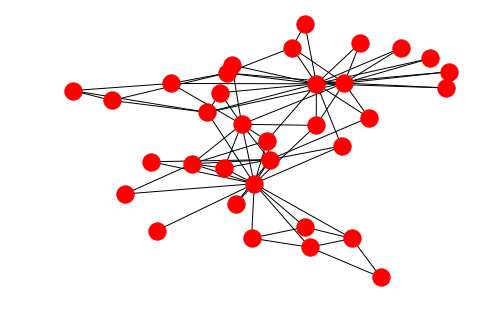

In [4]:
nx.draw(G)

In [5]:
for edge in G.edges():
    G[edge[0]][edge[1]]['weight'] = 1

In [6]:
G= G.to_undirected()

In [14]:
G.nodes()

NodeView((1, 32, 22, 20, 18, 14, 13, 12, 11, 9, 8, 7, 6, 5, 4, 3, 2, 31, 10, 33, 29, 28, 17, 34, 15, 16, 19, 21, 23, 24, 30, 26, 25, 27))

In [17]:
alias_nodes = {}
for node in G.nodes():
    unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
    norm_const = sum(unnormalized_probs)
    normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
    alias_nodes[node] = alias_setup(normalized_probs)

In [19]:
#alias_nodes